In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binom, poisson, geom
import math
import matplotlib.pyplot as plt
import timeit
from scipy.stats import linregress
from scipy.special import factorial

class Network ( object ) :
    def __init__ ( self , num_nodes ) :
        self . adj = { i :set () for i in range ( num_nodes ) }

    def add_edge ( self , i , j ) :
        self . adj [ i ]. add ( j )
        self . adj [ j ]. add ( i )

    def neighbors ( self , i ) :
        return self . adj [ i ]

    def edge_list ( self ) :    
        return [( i , j ) for i in self . adj for j in self . adj [ i ] if i < j ]

In [2]:
def generate_edge_list (k):
#n is the number of nodes, k is the degree distribution ( a list where k[i] is)
#the degree of node i)
    n = len ( k )
    S = np.array ([ i for i in range ( n ) for _ in range ( k [ i ]) ])
    S = np.random.permutation ( S )
    if len ( S ) % 2:
        S = S [: -1]
    S = S . reshape ( -1 , 2)
    return S

In [43]:
def generate_H():
    n = 150000
    s = 25000
    k_max = 1000

    #Homogenous network - mean = 6
    k = np.zeros (n, dtype=int)
    for i in range(n):
        k[i] = np.random.geometric(1/7)-1

    k = np.clip(k, None, k_max)

    S = generate_edge_list(k)
    H = Network(n)
    for i, j in S:
            H.add_edge(i, j)
    return H

def generate_I(student_mean, interconnections):
    n = 150000
    s = 25000
    k_max = 1000
    p = 1/(student_mean+1)
    k_students = np.random.geometric(p, size=s)
    k_students = k_students -1 
    
    k_students = np.clip(k_students, None, k_max)


    mean = (900000 - 150000 - interconnections*50000)/125000

    k_non_students = np.random.geometric(1/(mean+1), size=n - s)
    k_non_students = k_non_students - 1

    k_non_students = np.clip(k_non_students, None, k_max)

    S_edges = generate_edge_list(k_students)
    N_edges = generate_edge_list(k_non_students)
    N_edges_shifted = [(i + s, j + s) for i, j in N_edges]
    
    num_edges_per_student = np.random.poisson(interconnections, size=s)
    student_nodes = np.repeat(np.arange(s), num_edges_per_student)
    num_inter = len(student_nodes)

    targets = np.random.randint(s, n, size=num_inter)
    inter_edges = np.stack([student_nodes, targets], axis=1)

    all_edges = np.vstack((S_edges, N_edges_shifted, inter_edges))
        
    I = Network(n)
    for i, j in all_edges:
        I.add_edge(i, j)   

    return I

In [37]:
def simulation_setup (n, starting_infected):
    #pick starting fraction in I
    p_0 = starting_infected * n

    #randomly pick starting nodes
    I_0 = set()
    for i in range(int(p_0)):
        k = np.random.randint(0, n)
        while k in I_0:
            k = np.random.randint(0, n)
        I_0.add(k)

    R_0 = set()

    S_0 = set()
    for i in range(n):
        if i not in I_0:
            S_0.add(i)

    return S_0, I_0, R_0

In [38]:
def run_week(S, I, R, G, λ):
    R_copy = R.copy()
    S_copy = S.copy()
    I_copy = I.copy()


    for i in I:
        for j in G.neighbors(i):
            if j in S_copy:
                if np.random.uniform(0, 1) < λ:
                    S_copy.remove(j)
                    I_copy.add(j)
        I_copy.remove(i)
        R_copy.add(i)

    S = S_copy
    I = I_copy
    R = R_copy


    return S, I, R

In [39]:
def run_simulation (G, I_0, R_0, S_0, λ, weeks):
    Susceptible = []
    Infectious = []
    Recovered = []

    Susceptible.append(len(S_0))
    Infectious.append(len(I_0))
    Recovered.append(len(R_0))

    for i in range(weeks):
        S_0, I_0, R_0 = run_week(S_0, I_0, R_0, G, λ)
        Susceptible.append(len(S_0))
        Infectious.append(len(I_0))
        Recovered.append(len(R_0))

    return Susceptible, Infectious, Recovered

0.0
0.05555555555555555
0.1111111111111111
0.16666666666666666
0.2222222222222222
0.2777777777777778
0.3333333333333333
0.38888888888888884
0.4444444444444444
0.5


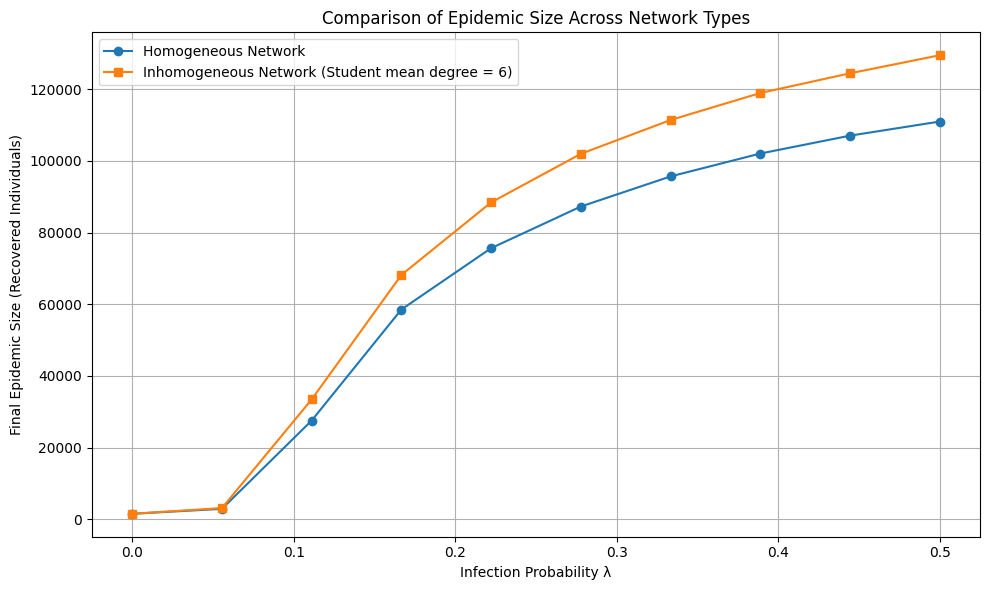

In [8]:
n =150000
H = generate_H()
I = generate_I(6, 0)
weeks =100

lamdas = np.linspace(0, 0.5, 10)

H_epidemics = []
I_epidemics = []


for λ in lamdas:
    print(λ)
    S_0, I_0, R_0 = simulation_setup(n, 0.01)
    Susceptible, Infectious, Recovered = run_simulation(H, I_0, R_0, S_0, λ, weeks)
    H_epidemics.append(Recovered[-1])
    Susceptible, Infectious, Recovered = run_simulation(I, I_0, R_0, S_0, λ, weeks)
    I_epidemics.append(Recovered[-1])


plt.figure(figsize=(10, 6))
plt.plot(lamdas, H_epidemics, label='Homogeneous Network', marker='o')
plt.plot(lamdas, I_epidemics, label='Inhomogeneous Network (Student mean degree = 6)', marker='s')

plt.xlabel('Infection Probability λ')
plt.ylabel('Final Epidemic Size (Recovered Individuals)')
plt.title('Comparison of Epidemic Size Across Network Types')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This shows that compartmentalisation can increase the outbreak size, even if overall edge number (and therefore overall mean degree) is kept constant.

I.e. mean degree in homogenous graph is 6. - 450000 edges
in inhomogenous graph mean degree in students is 6. we can adjust mean interconnections and mean degree for the non student group accordingly so that total edges always kept constant. We find regardless of the combination chosen for interconnections and non_student mean degree, the inhomogenous graph experiences larger outbreaks, across all relevant lambda values.

In [23]:
I = generate_I(6, 2)
n=150000
λ = 1
I_epidemics = []
S_0, I_0, R_0 = simulation_setup(n, 0.01)
Susceptible, Infectious, Recovered = run_simulation(I, I_0, R_0, S_0, λ, weeks)
I_epidemics.append(Recovered[-1])

In [25]:
print(Recovered[-1])

149742


0
3
6
9
12


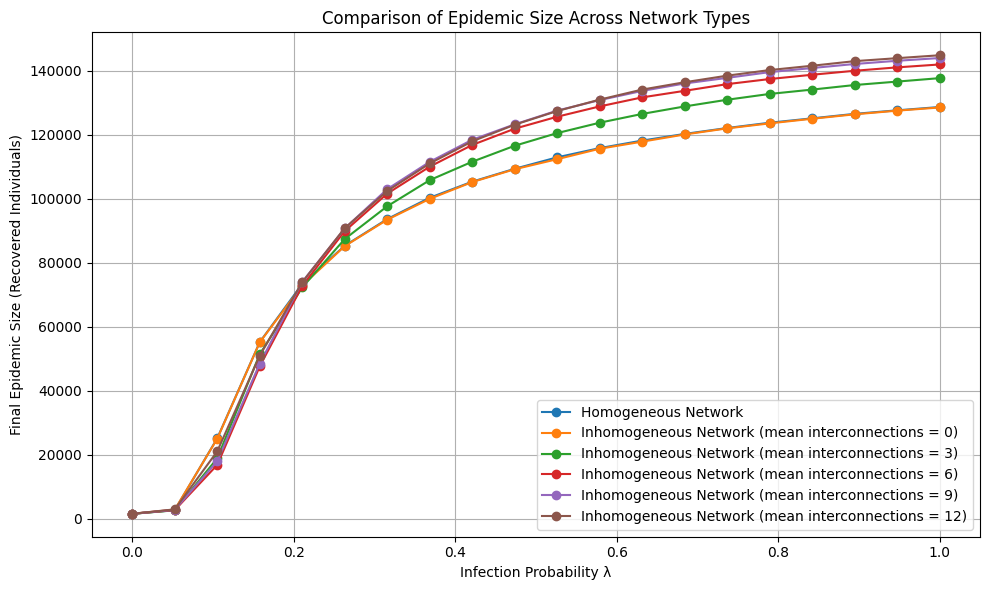

In [46]:
n =150000
H = generate_H()
weeks =100

interconnections = [0, 3, 6, 9, 12]
lamdas = np.linspace(0, 1, 20)

H_epidemics = []

for λ in lamdas:
    S_0, I_0, R_0 = simulation_setup(n, 0.01)
    Susceptible, Infectious, Recovered = run_simulation(H, I_0, R_0, S_0, λ, weeks)
    H_epidemics.append(Recovered[-1])

for i in interconnections:
    I = generate_I(6, i)
    I_epidemics = []
    print(i)
    for λ in lamdas:
        S_0, I_0, R_0 = simulation_setup(n, 0.01)
        Susceptible, Infectious, Recovered = run_simulation(I, I_0, R_0, S_0, λ, weeks)
        I_epidemics.append(Recovered[-1])
    if i == 0:
        A_0 = I_epidemics
    if i == 3:
        A_1 = I_epidemics
    if i == 6:
        A_2 = I_epidemics
    if i == 9:
        A_3 = I_epidemics
    if i == 12:
        A_4 = I_epidemics
    #if i == 15:
        #A_5 = I_epidemics


plt.figure(figsize=(10, 6))
plt.plot(lamdas, H_epidemics, label='Homogeneous Network', marker='o')
plt.plot(lamdas, A_0, label='Inhomogeneous Network (mean interconnections = 0)', marker='o')
plt.plot(lamdas, A_1, label='Inhomogeneous Network (mean interconnections = 3)', marker='o')
plt.plot(lamdas, A_2, label='Inhomogeneous Network (mean interconnections = 6)', marker='o')
plt.plot(lamdas, A_3, label='Inhomogeneous Network (mean interconnections = 9)', marker='o')
plt.plot(lamdas, A_4, label='Inhomogeneous Network (mean interconnections = 12)', marker='o')
#plt.plot(lamdas, A_5, label='Inhomogeneous Network (mean interconnections = 15)', marker='o')
plt.xlabel('Infection Probability λ')
plt.ylabel('Final Epidemic Size (Recovered Individuals)')
plt.title('Comparison of Epidemic Size Across Network Types')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
def generate_H():
    n = 150000
    s = 25000
    k_max = 1000

    #Homogenous network - mean = 6
    k = np.zeros (n, dtype=int)
    for i in range(n):
        k[i] = np.random.geometric(1/6)

    k = np.clip(k, None, k_max)

    S = generate_edge_list(k)
    H = Network(n)
    for i, j in S:
            H.add_edge(i, j)
    return H

def generate_I(student_mean, interconnections):
    n = 150000
    s = 25000
    k_max = 1000
    p = 1/(student_mean)
    k_students = np.random.geometric(p, size=s)
    k_students = np.clip(k_students, None, k_max)


    mean = (900000 - 150000 - interconnections*50000)/125000

    k_non_students = np.random.geometric(1/(mean), size=n - s)
    k_non_students = np.clip(k_non_students, None, k_max)

    S_edges = generate_edge_list(k_students)
    N_edges = generate_edge_list(k_non_students)
    N_edges_shifted = [(i + s, j + s) for i, j in N_edges]
    
    num_edges_per_student = np.random.poisson(interconnections, size=s)
    student_nodes = np.repeat(np.arange(s), num_edges_per_student)
    num_inter = len(student_nodes)

    targets = np.random.randint(s, n, size=num_inter)
    inter_edges = np.stack([student_nodes, targets], axis=1)

    all_edges = np.vstack((S_edges, N_edges_shifted, inter_edges))
        
    I = Network(n)
    for i, j in all_edges:
        I.add_edge(i, j)   

    return I

0
3
6
9
12


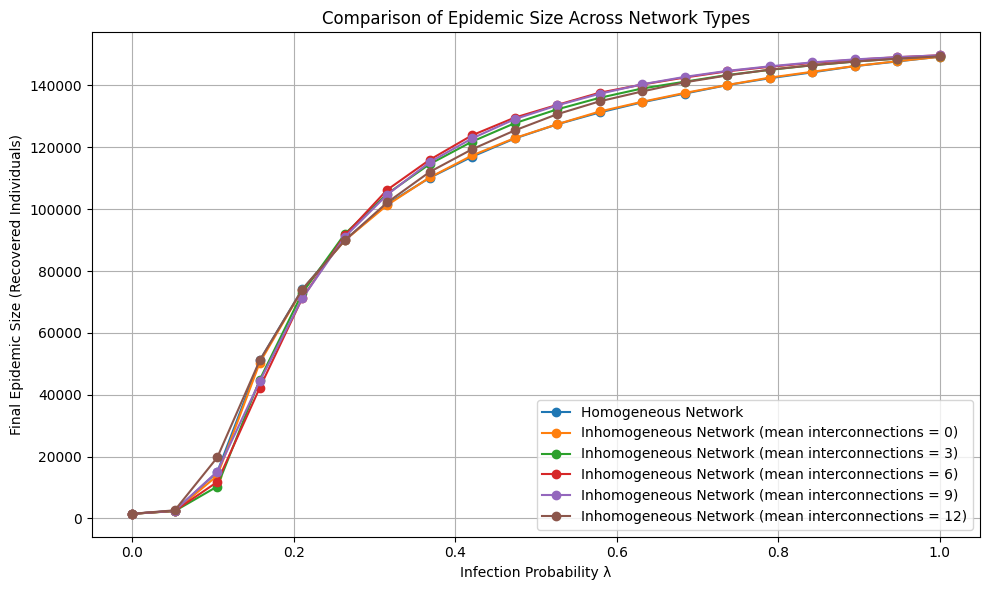

In [48]:
n =150000
H = generate_H()
weeks =100

interconnections = [0, 3, 6, 9, 12]
lamdas = np.linspace(0, 1, 20)

H_epidemics = []

for λ in lamdas:
    S_0, I_0, R_0 = simulation_setup(n, 0.01)
    Susceptible, Infectious, Recovered = run_simulation(H, I_0, R_0, S_0, λ, weeks)
    H_epidemics.append(Recovered[-1])

for i in interconnections:
    I = generate_I(6, i)
    I_epidemics = []
    print(i)
    for λ in lamdas:
        S_0, I_0, R_0 = simulation_setup(n, 0.01)
        Susceptible, Infectious, Recovered = run_simulation(I, I_0, R_0, S_0, λ, weeks)
        I_epidemics.append(Recovered[-1])
    if i == 0:
        A_0 = I_epidemics
    if i == 3:
        A_1 = I_epidemics
    if i == 6:
        A_2 = I_epidemics
    if i == 9:
        A_3 = I_epidemics
    if i == 12:
        A_4 = I_epidemics
    #if i == 15:
        #A_5 = I_epidemics


plt.figure(figsize=(10, 6))
plt.plot(lamdas, H_epidemics, label='Homogeneous Network', marker='o')
plt.plot(lamdas, A_0, label='Inhomogeneous Network (mean interconnections = 0)', marker='o')
plt.plot(lamdas, A_1, label='Inhomogeneous Network (mean interconnections = 3)', marker='o')
plt.plot(lamdas, A_2, label='Inhomogeneous Network (mean interconnections = 6)', marker='o')
plt.plot(lamdas, A_3, label='Inhomogeneous Network (mean interconnections = 9)', marker='o')
plt.plot(lamdas, A_4, label='Inhomogeneous Network (mean interconnections = 12)', marker='o')
#plt.plot(lamdas, A_5, label='Inhomogeneous Network (mean interconnections = 15)', marker='o')
plt.xlabel('Infection Probability λ')
plt.ylabel('Final Epidemic Size (Recovered Individuals)')
plt.title('Comparison of Epidemic Size Across Network Types')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()